In [7]:
# TODO: Make all necessary imports.
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import json
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

# TODO: Create a training set, a validation set and a test set.
train_dataset, test_dataset, valid_dataset = dataset['train'], dataset['test'], dataset['validation']

In [9]:
# TODO: Get the number of examples in each set from the dataset info.

train_size = dataset_info.splits['train'].num_examples
test_size = dataset_info.splits['test'].num_examples
val_size = dataset_info.splits['validation'].num_examples

print(f'number of training examples: {train_size}')
print(f'number of testing examples: {test_size}')
print(f'number of validation examples: {val_size}')

# TODO: Get the number of classes in the dataset from the dataset info.

num_classes = dataset_info.features['label'].num_classes
print('number of classes: ', num_classes)

number of training examples: 1020
number of testing examples: 6149
number of validation examples: 1020
number of classes:  102


In [10]:
# TODO: Print the shape and corresponding label of 3 images in the training set.

for image, label in train_dataset.take(3):
    print(f'Image shape: {image.shape}, Label: {label.numpy()}')

Image shape: (500, 667, 3), Label: 72
Image shape: (500, 666, 3), Label: 84
Image shape: (670, 500, 3), Label: 70


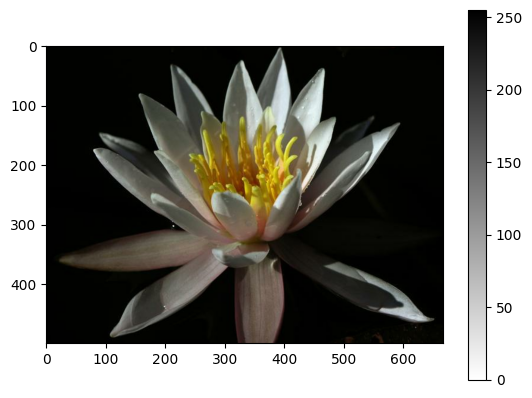

The label of this image is: 72


In [11]:
# TODO: Plot 1 image from the training set. Set the title
# of the plot to the corresponding image label.

for image, label in train_dataset.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)

In [13]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

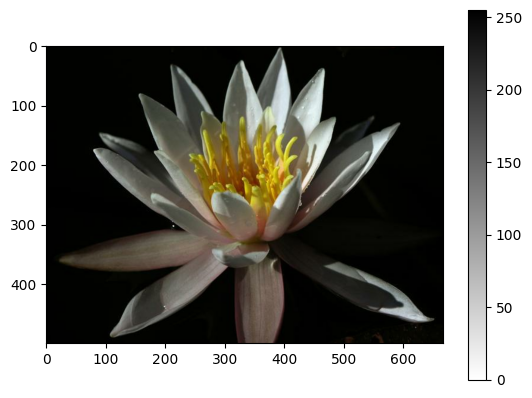

The class name of this image is: water lily


In [14]:
# TODO: Plot 1 image from the training set. Set the title
# of the plot to the corresponding class name.

for image, label in train_dataset.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.show()

print('The class name of this image is:', class_names[str(label)])

In [15]:
# TODO: Create a pipeline for each set.

def normalize(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize images to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

batch_size = 64

training_batches = (train_dataset
                    .cache()
                    .shuffle(train_size // 4)
                    .map(normalize)
                    .batch(batch_size)
                    .prefetch(tf.data.AUTOTUNE))

validation_batches = (valid_dataset
                      .cache()
                      .map(normalize)
                      .batch(batch_size)
                      .prefetch(tf.data.AUTOTUNE))

testing_batches = (test_dataset
                   .cache()
                   .map(normalize)
                   .batch(batch_size)
                   .prefetch(tf.data.AUTOTUNE))

In [16]:
# TODO: Build and train your network.

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

LEARNING_RATE = 0.001
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 20

history = model.fit(training_batches,
                    validation_data=validation_batches,
                    epochs=EPOCHS)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0272 - loss: 4.8432 - val_accuracy: 0.1971 - val_loss: 3.6853
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.4638 - loss: 3.0209 - val_accuracy: 0.5049 - val_loss: 2.6889
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7881 - loss: 1.9347 - val_accuracy: 0.6382 - val_loss: 2.0758
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9059 - loss: 1.2564 - val_accuracy: 0.7098 - val_loss: 1.7182
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9476 - loss: 0.8565 - val_accuracy: 0.7382 - val_loss: 1.4918
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9794 - loss: 0.6506 - val_accuracy: 0.7500 - val_loss: 1.3469
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9859 - loss: 0.4927 - val_accuracy: 0.7588 - val_loss: 1.2480
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - acc

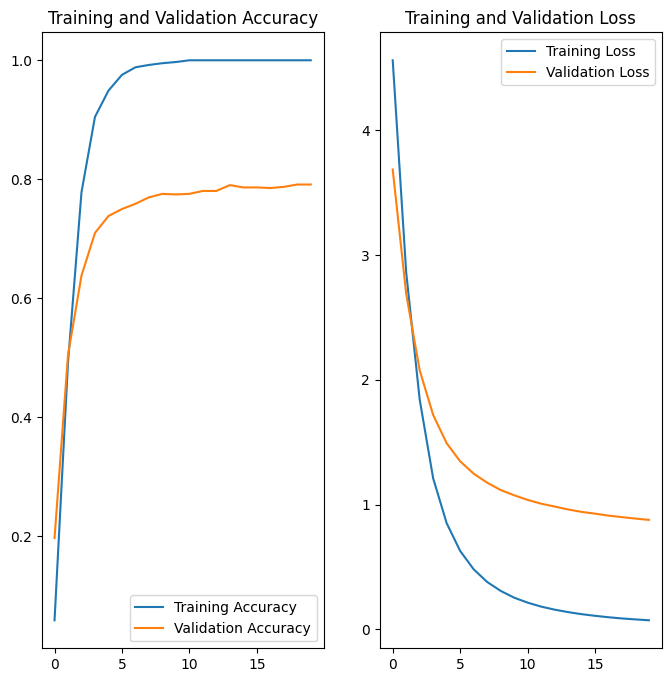

In [17]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(len(training_accuracy))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(testing_batches)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# TODO: Save your trained model as a Keras model.

filepath = 'new_model.keras'

model.save(filepath)

In [ ]:
# TODO: Load the Keras model

model = tf.keras.models.load_model(filepath)

In [21]:
# TODO: Create the process_image function

def process_image(image):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_resized = tf.image.resize(image_tensor, (224, 224))
    image_normalized = image_resized / 255.0
    return image_normalized.numpy()

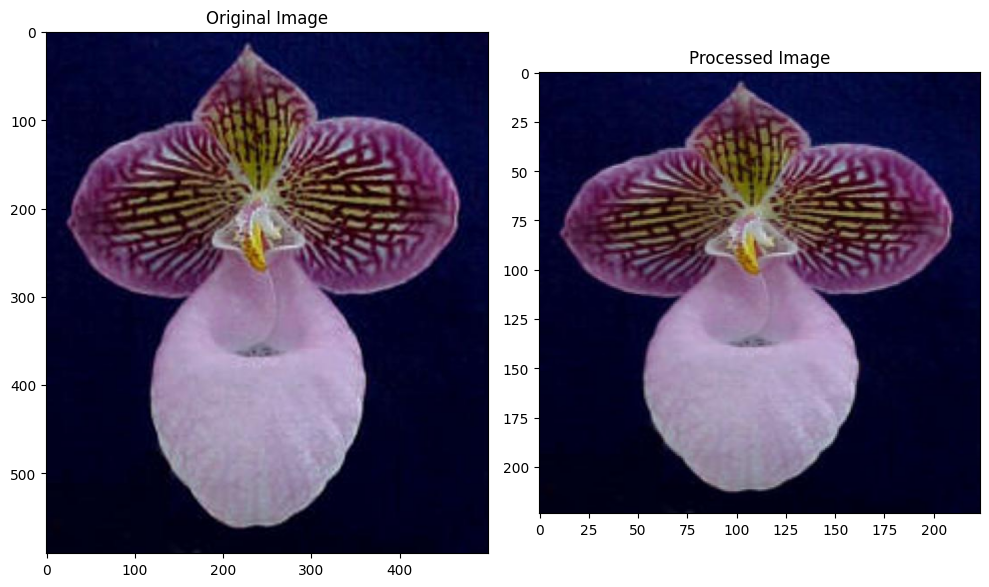

In [22]:
image_path = '/content/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [23]:
# TODO: Create the predict function

def predict(image_path: str, model, top_k: int = 5):

    image = Image.open(image_path)
    image = np.asarray(image)
    processed_image = process_image(image)

    processed_image = np.expand_dims(processed_image, axis=0)

    predictions = model.predict(processed_image)

    top_k_probs = np.squeeze(predictions)
    top_k_indices = np.argsort(top_k_probs)[-top_k:][::-1]

    probs = top_k_probs[top_k_indices]
    classes = top_k_indices.astype(str)

    return probs, classes

probs, classes = predict(image_path, model, top_k=5)
print(probs)
print(classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[9.9348611e-01 1.3150699e-03 7.7931694e-04 6.8235560e-04 5.1639305e-04]
['1' '67' '6' '5' '90']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


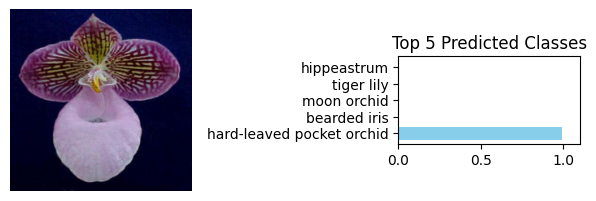

In [28]:
# TODO: Plot the input image along with the top 5 classes

image_path = '/content/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)
processed_test_image = process_image(test_image)

processed_image = np.expand_dims(processed_test_image, axis=0)

ps = model.predict(processed_image)

top_k = 5
top_k_indices = np.argsort(ps[0])[-top_k:][::-1]
top_k_probs = ps[0][top_k_indices]

top_k_labels = [class_names[str(i)] for i in top_k_indices]

fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
ax1.imshow(processed_test_image, cmap=plt.cm.binary)
ax1.axis('off')

ax2.barh(top_k_labels, top_k_probs, color='skyblue')
ax2.set_aspect(0.1)
ax2.set_title('Top 5 Predicted Classes')
ax2.set_xlim(0, 1.1)


plt.tight_layout()
plt.show()